# 论文本地化

本部分主要是讨论国内上市企业的股利变化是否会暗示存在“未来收益”信息，本部分由于时间限制，直接采用了论文（Ham C. et al. 2019）内的基本模型1的第七个控制变量方法，具体可见下式：

$$\Delta E_{it+n} = \beta_{0} + \beta_{1}\Delta DIV_{it} + \Sigma \beta_{j} Controls + \epsilon $$
其中，$\Delta E_{it+n}$取一季度，即$\Delta E_{q+1}$，而模型中的Controls则包含了,
$$E_{q-1} \to E_{q-4}, \Delta E_{q-1} \to \Delta E_{q-4}, and Ret_{-2 \to -240} $$

本节主要从以下几个方向展开，

1. 基本的假设叙述
2. A股市场的描述性统计
3. 模型结果
4. 应用结果

用到的股票数据源为[Tushare](https://tushare.pro/), 使用的应用结果由[RiceQuant](https://www.ricequant.com/welcome/)支持。其中的统计工具主要由[statsmodels](http://www.statsmodels.org/)支持。(Seabold, et al.2010)

#### 依赖

* Anaconda 3
* tushare: pip install tushare
* statsmodels: pip install statsmodels


## 基本假设

1. 本文选取的股票不考虑金融行业股票（行业分类采用申万一级行业分类标准）
2. 仅考虑现金分红，而不考虑送、转两形式
3. 年份调整为2000年1月1日至2018年12月31日

In [185]:
# 初始化Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

In [212]:
# 工具初始化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tushare as ts
import time
# tushare 初始化
TUSAHRE_TOKEN = "771fdb0b5817e36524299af6c12c19a3679e99c378c87d109ff138e2"
ts.set_token(TUSAHRE_TOKEN)
# tushare api初始化
pro = ts.pro_api()

In [110]:
# 行业筛选
INDUSTY = 0
INDUSTY = pro.index_classify(level='L1', src='SW')
INDUSTY.drop(index = [25,26,27], inplace=True) # 删除银行、非银金融、综合类
print(INDUSTY)
# 由行业给出具体的证券
STOCKS = []
for sub_industry in INDUSTY["index_code"]:
    stocks_list = pro.index_member(index_code=sub_industry)
    STOCKS += list(stocks_list["con_code"])
print("证券初筛，共" + str(len(STOCKS)) + "只非金融类证券") #结果上，我们筛选出了3486支初步符合要求的证券

   index_code industry_name level
0   801020.SI            采掘    L1
1   801030.SI            化工    L1
2   801040.SI            钢铁    L1
3   801050.SI          有色金属    L1
4   801710.SI          建筑材料    L1
5   801720.SI          建筑装饰    L1
6   801730.SI          电气设备    L1
7   801890.SI          机械设备    L1
8   801740.SI          国防军工    L1
9   801880.SI            汽车    L1
10  801110.SI          家用电器    L1
11  801130.SI          纺织服装    L1
12  801140.SI          轻工制造    L1
13  801200.SI          商业贸易    L1
14  801010.SI          农林牧渔    L1
15  801120.SI          食品饮料    L1
16  801210.SI          休闲服务    L1
17  801150.SI          医药生物    L1
18  801160.SI          公用事业    L1
19  801170.SI          交通运输    L1
20  801180.SI           房地产    L1
21  801080.SI            电子    L1
22  801750.SI           计算机    L1
23  801760.SI            传媒    L1
24  801770.SI            通信    L1
证券初筛，共3486只非金融类证券


In [ ]:
# 两大基本指数 SZ SH 
SZ_INDEX = "399001.SZ"
SH_INDEX = "000001.SH"
SZ_TRADING = pro.index_daily(ts_code=SZ_INDEX, start_date="20000101")
SH_TRADING = pro.index_daily(ts_code=SH_INDEX, start_date="20000101")
SZ_TRADING["trade_date"] = list(map(int, SZ_TRADING["trade_date"].values))
SH_TRADING["trade_date"] = list(map(int, SH_TRADING["trade_date"].values))

In [ ]:
# 证券分红数据获取 (改变base_stocks 到全STOCKS)
base_stocks = STOCKS
df_dividend = pro.dividend(ts_code=STOCKS[0], fields='ts_code,div_proc,ann_date,stk_div,record_date,ex_date')
df_dividend = df_dividend[df_dividend["div_proc"]=="实施"]

for stocks in base_stocks:
    df_new = pro.dividend(ts_code=stocks, fields='ts_code,div_proc,ann_date,stk_div,record_date,ex_date')
    df_new = df_new[df_new["div_proc"]=="实施"]
    df_dividend = df_dividend.append(df_new, ignore_index=True)
    time.sleep(60/300)
    

# 年份数据调整
def date_ann(df):
    df["year"] = list(map(int,df["year"].values))
def date_year(divd_ann):
    year = []
    for i in divd_ann:
        year.append(int(i[:4]))
    return year
def base_date_filter(df):
    df["year"] = date_year(df["ann_date"].values)
    df["ann_date"] = list(map(int,df["ann_date"].values))
    orders_new = ['ts_code','ann_date','year','div_proc','stk_div']
    df = df[orders_new]
    return df
#————————————————————213——————————————————————#
df_dividend = base_date_filter(df_dividend.dropna())

# TODO：考虑当不存在分红年份的时候，是否需要补入数据？

# df_dividend_perc
def divd_change_percent(df):
    base_stocks = newdf["ts_code"].unique()
    div_change_per = []
    for i in base_stocks:
        temp = df[df["ts_code"]==i]
        for j in range(len(temp)-1):
            divs = temp["stk_div"].values
            if float(divs[j+1]) == 0:
                divs[j+1] = 0.000000001
            change_per = (float(divs[j])-float(divs[j+1]))/float(divs[j+1])
            # 异常值设定上限处理，本点存在问题，采取逻辑依照十倍上限
            if change_per > 5:
                change_per = 5
            div_change_per.append(change_per)
        div_change_per.append("起始日")
    df["div_chg_per"] = div_change_per
    df = df[df["div_chg_per"]!="起始日"]
    return df
df_dividend = divd_change_percent(df_dividend)

# 同步获取证券的交易信息（从2001-2019）；分红日前2-240收益信息
def control_240(new2df):
    #超额收益列初始化
    prima_20 = []
    prima_40 = []
    prima_60 = []
    prima_120 = []
    prima_240 = []

    for i in range(len(new2df)):
        # 证券标的
        test_code = new2df["ts_code"].iloc[i]

        # 获取证券交易信息
        test_code_stock_df = pro.daily(ts_code=test_code, start_date='20000101')
        test_code_stock_df["trade_date"] = list(map(int, test_code_stock_df["trade_date"].values))
        if test_code[-1] == "H":
            test_code_stock_large = pd.merge(test_code_stock_df,SH_TRADING,on="trade_date")
        else:
            test_code_stock_large = pd.merge(test_code_stock_df,SH_TRADING,on="trade_date")
        # test_code_stock_large
        test_code_stock_large["prima_return"] = test_code_stock_large["pct_chg_x"] - test_code_stock_large["pct_chg_y"]

        test_date_base = new2df["ann_date"].iloc[i]
        test_code_stock_large_select = test_code_stock_large[test_code_stock_large["trade_date"]<test_date_base][0:240]
        prima = (test_code_stock_large_select["prima_return"]/100) + 1
        #计算超额收益
        prima_20.append(np.prod(prima[1:20]) - 1)
        prima_40.append(np.prod(prima[20:40]) - 1)
        prima_60.append(np.prod(prima[40:60]) - 1)
        prima_120.append(np.prod(prima[60:120]) - 1)
        prima_240.append(np.prod(prima[120:]) - 1)

    # 添加超额列
    new2df["prima_20"] = prima_20
    new2df["prima_40"] = prima_40
    new2df["prima_60"] = prima_60
    new2df["prima_120"] = prima_120
    new2df["prima_240"] = prima_240
    
    return new2df

df_dividend = control_240(df_dividend)

# △E的处理，用季度数据

# 同步分红后一季度后收益

In [230]:
# TODO：考虑当不存在分红年份的时候，是否需要补入数据？

# df_dividend_perc
def divd_change_percent(df):
    base_stocks = df["ts_code"].unique()
    div_change_per = []
    for i in base_stocks:
        temp = df[df["ts_code"]==i]
        for j in range(len(temp)-1):
            divs = temp["stk_div"].values
            if float(divs[j+1]) == 0:
                divs[j+1] = 0.000000001
            change_per = (float(divs[j])-float(divs[j+1]))/float(divs[j+1])
            # 异常值设定上限处理，本点存在问题，采取逻辑依照十倍上限
            if change_per > 5:
                change_per = 5
            div_change_per.append(change_per)
        div_change_per.append("起始日")
    df["div_chg_per"] = div_change_per
    df = df[df["div_chg_per"]!="起始日"]
    return df
df_dividend = divd_change_percent(df_dividend)

# 同步获取证券的交易信息（从2001-2019）；分红日前2-240收益信息
def control_240(new2df):
    #超额收益列初始化
    prima_20 = []
    prima_40 = []
    prima_60 = []
    prima_120 = []
    prima_240 = []

    for i in range(len(new2df)):
        # 证券标的
        test_code = new2df["ts_code"].iloc[i]

        # 获取证券交易信息
        test_code_stock_df = pro.daily(ts_code=test_code, start_date='20000101')
        test_code_stock_df["trade_date"] = list(map(int, test_code_stock_df["trade_date"].values))
        if test_code[-1] == "H":
            test_code_stock_large = pd.merge(test_code_stock_df,SH_TRADING,on="trade_date")
        else:
            test_code_stock_large = pd.merge(test_code_stock_df,SH_TRADING,on="trade_date")
        # test_code_stock_large
        test_code_stock_large["prima_return"] = test_code_stock_large["pct_chg_x"] - test_code_stock_large["pct_chg_y"]

        test_date_base = new2df["ann_date"].iloc[i]
        test_code_stock_large_select = test_code_stock_large[test_code_stock_large["trade_date"]<test_date_base][0:240]
        prima = (test_code_stock_large_select["prima_return"]/100) + 1
        #计算超额收益
        prima_20.append(np.prod(prima[1:20]) - 1)
        prima_40.append(np.prod(prima[20:40]) - 1)
        prima_60.append(np.prod(prima[40:60]) - 1)
        prima_120.append(np.prod(prima[60:120]) - 1)
        prima_240.append(np.prod(prima[120:]) - 1)

    # 添加超额列
    new2df["prima_20"] = prima_20
    new2df["prima_40"] = prima_40
    new2df["prima_60"] = prima_60
    new2df["prima_120"] = prima_120
    new2df["prima_240"] = prima_240
    
    return new2df

df_dividend = control_240(df_dividend)

# △E的处理，用季度数据
lessdate = lambda x: int(int(x)/100)
ts_code_list = df_base["ts_code"].unique()
len(ts_code_list)

# 财务数据处理
fundmental_test = pro.income(ts_code=ts_code_list[0], report_type=2, start_date='20000101', 
           fields='ts_code, end_date, n_income').dropna()
fu2 = fundmental_test.drop_duplicates()
fu2["end_date"] = list(map(int, fu2["end_date"].values))
fu2["yyyy_mm"] = list(map(lessdate, fu2["end_date"].values))

# ——————季度水平调整
## TODOLIST： 本部分写成循环
normal_E = list(fu2["n_income"])

## 前一季度水平调整
normal_E.append(np.nan)
fu2["before_E_1"] = normal_E[1:]
## 前二季度水平调整
normal_E.append(np.nan)
fu2["before_E_2"] = normal_E[2:]
## 前三季度水平调整
normal_E.append(np.nan)
fu2["before_E_3"] = normal_E[3:]
## 前四季度水平调整
normal_E.append(np.nan)
fu2["before_E_4"] = normal_E[4:]


# ——————差额部分
## TODOLIST： 本部分写成循环
## 注意！ delta_E_q 是扣减上年同期水平
delta_E_q = []
## 前一季度水平调整
for n_income_q_new_order in range(len(fu2["n_income"])-4):
    delta_E_q.append(fu2["n_income"].iloc[n_income_q_new_order] - fu2["n_income"].iloc[n_income_q_new_order+4])
for i in range(4):
    delta_E_q.append(np.nan)
fu2["delta_E_q"] = delta_E_q
## 前二季度水平调整
delta_E_q.append(np.nan)
fu2["delta_E_q_2"] = delta_E_q[1:]
## 前三季度水平调整
delta_E_q.append(np.nan)
fu2["delta_E_q_3"] = delta_E_q[2:]
## 前四季度水平调整
delta_E_q.append(np.nan)
fu2["delta_E_q_4"] = delta_E_q[3:]
## 下一季度水平预测
for i in range(4):
    delta_E_q.insert(0,np.nan)
fu2["next_E"] = delta_E_q[:len(fu2["end_date"])]

fu2 = fu2.dropna()
# 获取对应的市值数据
total_mv_index = pro.daily_basic(ts_code=ts_code_list[0], 
                                 fields='ts_code,trade_date,total_mv')
total_mv_index["yyyy_mm"] = list(map(lessdate,total_mv_index["trade_date"].values))
# 提取出市值
total_mv_list = []
#月份来源计算
for i in range(len(fu2["yyyy_mm"])):
    yyyy_mm_fs = fu2["yyyy_mm"].iloc[i] # 循环 0 ->i
    try:
        temp_mv = total_mv_index[total_mv_index["yyyy_mm"]==yyyy_mm_fs].iloc[0]
        temp_mv = temp_mv["total_mv"]
        total_mv_list.append(temp_mv)
    except IndexError:
        total_mv_list.append(total_mv_list[-1])
# total_mv_list
fu2["total_mv"] = total_mv_list
# fu2
for i in range(len(ts_code_list)-1):
    i = i + 1
    # 财务数据处理
    fundmental_test = pro.income(ts_code=ts_code_list[i], report_type=2, start_date='20000101', 
               fields='ts_code, end_date, n_income').dropna()
    fu3 = fundmental_test.drop_duplicates()
    fu3["end_date"] = list(map(int, fu3["end_date"].values))
    fu3["yyyy_mm"] = list(map(lessdate, fu3["end_date"].values))

    # ——————季度水平调整
    ## TODOLIST： 本部分写成循环
    normal_E = list(fu3["n_income"])

    ## 前一季度水平调整
    normal_E.append(np.nan)
    fu3["before_E_1"] = normal_E[1:]
    ## 前二季度水平调整
    normal_E.append(np.nan)
    fu3["before_E_2"] = normal_E[2:]
    ## 前三季度水平调整
    normal_E.append(np.nan)
    fu3["before_E_3"] = normal_E[3:]
    ## 前四季度水平调整
    normal_E.append(np.nan)
    fu3["before_E_4"] = normal_E[4:]


    # ——————差额部分
    ## TODOLIST： 本部分写成循环
    ## 注意！ delta_E_q 是扣减上年同期水平
    delta_E_q = []
    ## 前一季度水平调整
    for n_income_q_new_order in range(len(fu3["n_income"])-4):
        delta_E_q.append(fu3["n_income"].iloc[n_income_q_new_order] - fu3["n_income"].iloc[n_income_q_new_order+4])
    for i in range(4):
        delta_E_q.append(np.nan)
    fu3["delta_E_q"] = delta_E_q
    ## 前二季度水平调整
    delta_E_q.append(np.nan)
    fu3["delta_E_q_2"] = delta_E_q[1:]
    ## 前三季度水平调整
    delta_E_q.append(np.nan)
    fu3["delta_E_q_3"] = delta_E_q[2:]
    ## 前四季度水平调整
    delta_E_q.append(np.nan)
    fu3["delta_E_q_4"] = delta_E_q[3:]
    ## 下一季度水平预测
    for i in range(4):
        delta_E_q.insert(0,np.nan)
    fu3["next_E"] = delta_E_q[:len(fu3["end_date"])]

    # 缩放数据的处理，获取市值数据
    fu3 = fu3.dropna()
    # 获取对应的市值数据
    total_mv_index = pro.daily_basic(ts_code=ts_code_list[i], 
                                     fields='ts_code,trade_date,total_mv')
    total_mv_index["yyyy_mm"] = list(map(lessdate,total_mv_index["trade_date"].values))
    # 提取出市值
    total_mv_list = []
    #月份来源计算
    for j in range(len(fu3["yyyy_mm"])):
        yyyy_mm_fs = fu3["yyyy_mm"].iloc[j] # 循环 0 ->i
        try:
            temp_mv = total_mv_index[total_mv_index["yyyy_mm"]==yyyy_mm_fs].iloc[0]
            temp_mv = temp_mv["total_mv"]
            total_mv_list.append(temp_mv)
        except IndexError:
            try:
                total_mv_list.append(total_mv_list[-1])
            except IndexError:
                total_mv_list.append(np.nan)
    # total_mv_list
    fu3["total_mv"] = total_mv_list    
    fu2 = fu2.append(fu3,ignore_index=True)
    
financial_statement_result = fu2.copy(deep=True)
df_dividend_result = df_dividend.copy(deep=True)

In [386]:
# 数据初始化
financial_statement_result = fu2.copy(deep=True)
df_dividend_result = df_dividend.copy(deep=True)

# 针对fu2和df_dividend的整合
# 逻辑结构处理
## 以df_dividend为基础，for的是df_dividend，通过df_dividend去套fu2内的数据
## df_dividend的ann_date中，包含了1-12月所有的月份，因此首先是进行分类
## 1-3 => Q1, 4-6 => Q2, 7-9 => Q3, 10-12 => Q4,
## 针对两个表全部链接成一个新的表，然后按照key合并dropna试试看

# 依照ann_date为标注，反正end_date也一样可以写一个函数

def date_tempkey(date_temp):
    temp_date_str = list(map(str, date_temp))
    date_key = []
    for i in temp_date_str:
        if int(i[4:6])<=3:
            date_key.append(i[:4]+"Q1")
        elif int(i[4:6])<=6:
            date_key.append(i[:4]+"Q2")
        elif int(i[4:6])<=9:
            date_key.append(i[:4]+"Q3")
        else:
            date_key.append(i[:4]+"Q4")
    return date_key
financial_statement_result["year_Q"] = date_tempkey(financial_statement_result["end_date"])
df_dividend_result["year_Q"] = date_tempkey(df_dividend_result["ann_date"])
merge_result = pd.merge(df_dividend_result, financial_statement_result)

print_col_names = ['ts_code',  'year_Q', 'stk_div', 'div_chg_per',
       'prima_20', 'prima_40', 'prima_60', 'prima_120', 'prima_240', 
       'n_income', 'before_E_1', 'before_E_2',
       'before_E_3', 'before_E_4', 'delta_E_q', 'delta_E_q_2', 'delta_E_q_3',
       'delta_E_q_4', 'next_E', 'total_mv']
merge_result = merge_result[print_col_names]
merge_result = merge_result.rename(columns={"delta_E_q":"delta_E_q_1"})
merge_result
# 标准化E数据
standard_bytotalmv = merge_result.copy(deep=True)

standard_bytotalmv["z_next_E"] = (standard_bytotalmv["next_E"]/standard_bytotalmv["total_mv"])/10000
for i in range(4):
    standard_bytotalmv["z_before_E_"+str(i+1)] = (standard_bytotalmv["before_E_"+str(i+1)]/standard_bytotalmv["total_mv"])/10000
    standard_bytotalmv["z_delta_E_q_"+str(i+1)] = (standard_bytotalmv["delta_E_q_"+str(i+1)]/standard_bytotalmv["total_mv"])/10000
    
standard_bytotalmv.columns
orders = ['ts_code', 'year_Q', 'stk_div', 'div_chg_per', 'prima_20', 'prima_40',
       'prima_60', 'prima_120', 'prima_240', 'z_next_E',
       'z_before_E_1', 'z_before_E_2', 'z_before_E_3', 'z_before_E_4', 
       'z_delta_E_q_1', 'z_delta_E_q_2', 'z_delta_E_q_3', 'z_delta_E_q_4']

final_print_7thmodel_result = standard_bytotalmv[orders].copy(deep=True)
final_print_7thmodel_result.to_csv("7thModelData.csv")

In [408]:
# 回归结果
model_X = final_print_7thmodel_result[['div_chg_per', 'prima_20', 'prima_40',
       'prima_60', 'prima_120', 'prima_240', 
       'z_before_E_1', 'z_before_E_2', 'z_before_E_3', 'z_before_E_4', 
       'z_delta_E_q_1', 'z_delta_E_q_2', 'z_delta_E_q_3', 'z_delta_E_q_4']]
model_Y = final_print_7thmodel_result["z_next_E"]
model_X = sm.add_constant(model_X)
mod = sm.OLS(model_Y.astype(float), model_X.astype(float))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               z_next_E   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     2059.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:09:15   Log-Likelihood:                 15145.
No. Observations:               19409   AIC:                        -3.026e+04
Df Residuals:                   19394   BIC:                        -3.014e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0033      0.001     -3.721

In [366]:
financial_statement_result

,ts_code,end_date,n_income,yyyy_mm,before_E_1,before_E_2,before_E_3,before_E_4,delta_E_q,delta_E_q_2,delta_E_q_3,delta_E_q_4,next_E,total_mv
0,600121.SH,20180630,1.331499e+08,201806,9.800506e+07,4.663867e+07,2.790823e+08,2.346068e+08,-1.014568e+08,-1.964822e+08,4.821799e+08,1.997421e+08,-7.217676e+07,3.858305e+05
1,600121.SH,20180331,9.800506e+07,201803,4.663867e+07,2.790823e+08,2.346068e+08,2.944873e+08,-1.964822e+08,4.821799e+08,1.997421e+08,3.059743e+08,-6.692125e+07,5.665616e+05
2,600121.SH,20171231,4.663867e+07,201712,2.790823e+08,2.346068e+08,2.944873e+08,-4.355412e+08,4.821799e+08,1.997421e+08,3.059743e+08,4.229815e+08,-1.636874e+07,6.102214e+05
3,600121.SH,20170930,2.790823e+08,201709,2.346068e+08,2.944873e+08,-4.355412e+08,7.934024e+07,1.997421e+08,3.059743e+08,4.229815e+08,-3.126859e+08,-1.502330e+08,6.833261e+05
4,600121.SH,20170630,2.346068e+08,201706,2.944873e+08,-4.355412e+08,7.934024e+07,-7.136752e+07,3.059743e+08,4.229815e+08,-3.126859e+08,3.658548e+08,-1.014568e+08,5.107177e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111337,300513.SZ,20170630,1.322510e+07,201706,-2.740035e+06,3.657884e+07,-6.162542e+06,1.108342e+07,2.141676e+06,2.221126e+05,-1.725796e+06,1.679075e+06,2.919399e+07,4.436009e+06
111338,300627.SZ,20180630,3.322655e+07,201806,1.249126e+07,6.482348e+07,3.021146e+07,2.498543e+07,8.241118e+06,3.145292e+06,1.025113e+07,2.073539e+06,-3.542317e+06,2.211792e+06
111339,300627.SZ,20180331,1.249126e+07,201803,6.482348e+07,3.021146e+07,2.498543e+07,9.345967e+06,3.145292e+06,1.025113e+07,2.073539e+06,1.102505e+07,5.076747e+06,2.211792e+06
111340,300627.SZ,20171231,6.482348e+07,201712,3.021146e+07,2.498543e+07,9.345967e+06,5.457235e+07,1.025113e+07,2.073539e+06,1.102505e+07,3.227545e+06,-2.392786e+07,2.211792e+06


In [371]:
temp = "20190307"
print(temp[:4],
     temp[4:6],
     int(temp[4:6]))
if int(temp[4:6])<=3:
    print("q1")
elif int(temp[4:6])<=6:
    print("q2")

2019 03 3
q1


In [94]:
# newdf = df_dividend.copy(deep=True)
# #newdf["year"] = df_dividend["ann_date"].values
# def date_year(divd_ann):
#     year = []
#     for i in divd_ann:
#         year.append(int(i[:4]))
#     return year
# newdf["year"] = date_year(newdf["ann_date"].values)

In [113]:
# def divd_change_percent(df):
#     base_stocks = newdf["ts_code"].unique()
#     div_change_per = []
#     for i in base_stocks:
#         temp = df[df["ts_code"]==i]
#         for j in range(len(temp)-1):
#             divs = temp["stk_div"].values
#             if float(divs[j+1]) == 0:
#                 divs[j+1] = 0.000000001
#             change_per = (float(divs[j])-float(divs[j+1]))/float(divs[j+1])
#             # 异常值设定上限处理，本点存在问题，采取逻辑依照十倍上限
#             if change_per > 10:
#                 change_per = 999.9/100
#             div_change_per.append(change_per)
#         div_change_per.append("起始日")
#     df["div_chg_per"] = div_change_per
#     df = df[df["div_chg_per"]!="起始日"]
#     return df
# # """
# #     ba2 = newdf["ts_code"].unique()
# #     div_change_per = []
# #     for i in ba2:
# #         temp = newdf[newdf["ts_code"]==i]
# #         for j in range(len(temp)-1):
# #             divs = temp["stk_div"].values
# #             if int(divs[j]) == int(divs[j+1]):
# #                 change_per = 0
# #             elif int(divs[j+1]) == 0:
# #                 change_per = 1
# #             else:
# #                 change_per = (int(divs[j])-int(divs[j+1]))/int(divs[j+1])
# #             div_change_per.append(change_per)
# #         div_change_per.append("起始日")
# #     newdf["div_chg_per"] = div_change_per
# #     newdf = newdf[newdf["div_chg_per"]!="起始日"]
# # newdf.head()
# # """

In [184]:
# # 从当日的大盘数据扣除/超额收益 (1 + pct_chg_stock - pct_chg_market)
# # 基本就是整个处理循环过程，ts_code的处理，随后调stock_chg和market_chg，再计算复利，从-2到-240
# # list出来就有-2，-20； -20，-40；-40，-60；-60，-120；-120，-240

# # 两大基本指数 SZ SH 
# SZ_INDEX = "399001.SZ"
# SH_INDEX = "000001.SH"
# SZ_TRADING = pro.index_daily(ts_code=SZ_INDEX, start_date="20000101")
# SH_TRADING = pro.index_daily(ts_code=SH_INDEX, start_date="20000101")
# SZ_TRADING["trade_date"] = list(map(int, SZ_TRADING["trade_date"].values))
# SH_TRADING["trade_date"] = list(map(int, SH_TRADING["trade_date"].values))


# # 选择一个股票处理（需要循环）
# # 逻辑上，选股票->选指数、选分红日期->分红日期前240天指数匹配计算->出复合回报率

# #超额收益列初始化
# prima_20 = []
# prima_40 = []
# prima_60 = []
# prima_120 = []
# prima_240 = []

# for i in range(len(new2df)):
#     # 证券标的
#     test_code = new2df["ts_code"].iloc[i]

#     # 获取证券交易信息
#     test_code_stock_df = pro.daily(ts_code=test_code, start_date='20000101')
#     test_code_stock_df["trade_date"] = list(map(int, test_code_stock_df["trade_date"].values))
#     if test_code[-1] == "H":
#         test_code_stock_large = pd.merge(test_code_stock_df,SH_TRADING,on="trade_date")
#     else:
#         test_code_stock_large = pd.merge(test_code_stock_df,SH_TRADING,on="trade_date")
#     # test_code_stock_large
#     test_code_stock_large["prima_return"] = test_code_stock_large["pct_chg_x"] - test_code_stock_large["pct_chg_y"]

#     test_date_base = new2df["ann_date"].iloc[i]
#     test_code_stock_large_select = test_code_stock_large[test_code_stock_large["trade_date"]<test_date_base][0:240]
#     prima = (test_code_stock_large_select["prima_return"]/100) + 1
#     #计算超额收益
#     prima_20.append(np.prod(prima[1:20]) - 1)
#     prima_40.append(np.prod(prima[20:40]) - 1)
#     prima_60.append(np.prod(prima[40:60]) - 1)
#     prima_120.append(np.prod(prima[60:120]) - 1)
#     prima_240.append(np.prod(prima[120:]) - 1)

# # 添加超额列
# new2df["prima_20"] = prima_20
# new2df["prima_40"] = prima_40
# new2df["prima_60"] = prima_60
# new2df["prima_120"] = prima_120
# new2df["prima_240"] = prima_240

/Users/giulio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/giulio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/giulio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [364]:
# test_code_stock_large_select = test_code_stock_large[test_code_stock_large["trade_date"]<test_date_base][0:240]
# prima = (test_code_stock_large_select["prima_return"]/100) + 1
# prima_3 = np.prod(prima[:3]) - 1
# prima_20 = np.prod(prima[1:20]) - 1
# prima_40 = np.prod(prima[20:40]) - 1
# prima_60 = np.prod(prima[40:60]) - 1
# prima_120 = np.prod(prima[60:120]) - 1
# prima_240 = np.prod(prima[120:]) - 1
# print(prima_3,prima_20, prima_40, prima_60, prima_120, prima_240)

In [237]:
df_dividend.describe()

,ann_date,year,stk_div,prima_20,prima_40,prima_60,prima_120,prima_240
count,2.481100e+04,24811.000000,24811.000000,24811.000000,24811.000000,24811.000000,24811.000000,24811.000000
mean,2.012247e+07,2012.208537,0.169263,0.023089,0.028273,0.007348,0.009811,0.070494
std,5.769555e+04,5.769120,0.348781,0.113535,0.113012,0.119444,0.233976,0.423504
min,1.992020e+07,1992.000000,0.000000,-0.588919,-0.537842,-0.673210,-0.772049,-0.782229
25%,2.008082e+07,2008.000000,0.000000,-0.037041,-0.030201,-0.054336,-0.112480,-0.110682
50%,2.014032e+07,2014.000000,0.000000,0.001260,0.006625,0.000000,-0.000697,0.000000
75%,2.017041e+07,2017.000000,0.200000,0.067313,0.071546,0.051557,0.085091,0.148809
max,2.019083e+07,2019.000000,3.000000,2.546712,1.577424,2.711854,7.873025,11.165168


In [303]:
#————————————————————————————————20191019——————————————————————————————————#
df_base = df_dividend.copy(deep=True)
df_base.head()
df_base.to_csv("df_base_data.csv")

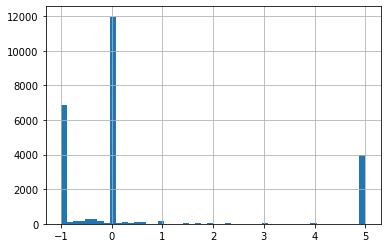

In [241]:
df_base["div_chg_per"].hist(bins=50)

# 本部分为财务正式处理过程

In [347]:
lessdate = lambda x: int(int(x)/100)
ts_code_list = df_base["ts_code"].unique()
len(ts_code_list)

3313

In [409]:
# # 财务数据处理
# fundmental_test = pro.income(ts_code=ts_code_list[0], report_type=2, start_date='20000101', 
#            fields='ts_code, end_date, n_income').dropna()
# fu2 = fundmental_test.drop_duplicates()
# fu2["end_date"] = list(map(int, fu2["end_date"].values))
# fu2["yyyy_mm"] = list(map(lessdate, fu2["end_date"].values))

# # ——————季度水平调整
# ## TODOLIST： 本部分写成循环
# normal_E = list(fu2["n_income"])

# ## 前一季度水平调整
# normal_E.append(np.nan)
# fu2["before_E_1"] = normal_E[1:]
# ## 前二季度水平调整
# normal_E.append(np.nan)
# fu2["before_E_2"] = normal_E[2:]
# ## 前三季度水平调整
# normal_E.append(np.nan)
# fu2["before_E_3"] = normal_E[3:]
# ## 前四季度水平调整
# normal_E.append(np.nan)
# fu2["before_E_4"] = normal_E[4:]


# # ——————差额部分
# ## TODOLIST： 本部分写成循环
# ## 注意！ delta_E_q 是扣减上年同期水平
# delta_E_q = []
# ## 前一季度水平调整
# for n_income_q_new_order in range(len(fu2["n_income"])-4):
#     delta_E_q.append(fu2["n_income"].iloc[n_income_q_new_order] - fu2["n_income"].iloc[n_income_q_new_order+4])
# for i in range(4):
#     delta_E_q.append(np.nan)
# fu2["delta_E_q"] = delta_E_q
# ## 前二季度水平调整
# delta_E_q.append(np.nan)
# fu2["delta_E_q_2"] = delta_E_q[1:]
# ## 前三季度水平调整
# delta_E_q.append(np.nan)
# fu2["delta_E_q_3"] = delta_E_q[2:]
# ## 前四季度水平调整
# delta_E_q.append(np.nan)
# fu2["delta_E_q_4"] = delta_E_q[3:]
# ## 下一季度水平预测
# for i in range(4):
#     delta_E_q.insert(0,np.nan)
# fu2["next_E"] = delta_E_q[:len(fu2["end_date"])]

# fu2 = fu2.dropna()
# # 获取对应的市值数据
# total_mv_index = pro.daily_basic(ts_code=ts_code_list[0], 
#                                  fields='ts_code,trade_date,total_mv')
# total_mv_index["yyyy_mm"] = list(map(lessdate,total_mv_index["trade_date"].values))
# # 提取出市值
# total_mv_list = []
# #月份来源计算
# for i in range(len(fu2["yyyy_mm"])):
#     yyyy_mm_fs = fu2["yyyy_mm"].iloc[i] # 循环 0 ->i
#     try:
#         temp_mv = total_mv_index[total_mv_index["yyyy_mm"]==yyyy_mm_fs].iloc[0]
#         temp_mv = temp_mv["total_mv"]
#         total_mv_list.append(temp_mv)
#     except IndexError:
#         total_mv_list.append(total_mv_list[-1])
# # total_mv_list
# fu2["total_mv"] = total_mv_list
# # fu2


# for i in range(len(ts_code_list)-1):
#     i = i + 1
#     # 财务数据处理
#     fundmental_test = pro.income(ts_code=ts_code_list[i], report_type=2, start_date='20000101', 
#                fields='ts_code, end_date, n_income').dropna()
#     fu3 = fundmental_test.drop_duplicates()
#     fu3["end_date"] = list(map(int, fu3["end_date"].values))
#     fu3["yyyy_mm"] = list(map(lessdate, fu3["end_date"].values))

#     # ——————季度水平调整
#     ## TODOLIST： 本部分写成循环
#     normal_E = list(fu3["n_income"])

#     ## 前一季度水平调整
#     normal_E.append(np.nan)
#     fu3["before_E_1"] = normal_E[1:]
#     ## 前二季度水平调整
#     normal_E.append(np.nan)
#     fu3["before_E_2"] = normal_E[2:]
#     ## 前三季度水平调整
#     normal_E.append(np.nan)
#     fu3["before_E_3"] = normal_E[3:]
#     ## 前四季度水平调整
#     normal_E.append(np.nan)
#     fu3["before_E_4"] = normal_E[4:]


#     # ——————差额部分
#     ## TODOLIST： 本部分写成循环
#     ## 注意！ delta_E_q 是扣减上年同期水平
#     delta_E_q = []
#     ## 前一季度水平调整
#     for n_income_q_new_order in range(len(fu3["n_income"])-4):
#         delta_E_q.append(fu3["n_income"].iloc[n_income_q_new_order] - fu3["n_income"].iloc[n_income_q_new_order+4])
#     for i in range(4):
#         delta_E_q.append(np.nan)
#     fu3["delta_E_q"] = delta_E_q
#     ## 前二季度水平调整
#     delta_E_q.append(np.nan)
#     fu3["delta_E_q_2"] = delta_E_q[1:]
#     ## 前三季度水平调整
#     delta_E_q.append(np.nan)
#     fu3["delta_E_q_3"] = delta_E_q[2:]
#     ## 前四季度水平调整
#     delta_E_q.append(np.nan)
#     fu3["delta_E_q_4"] = delta_E_q[3:]
#     ## 下一季度水平预测
#     for i in range(4):
#         delta_E_q.insert(0,np.nan)
#     fu3["next_E"] = delta_E_q[:len(fu3["end_date"])]

#     # 缩放数据的处理，获取市值数据
#     fu3 = fu3.dropna()
#     # 获取对应的市值数据
#     total_mv_index = pro.daily_basic(ts_code=ts_code_list[i], 
#                                      fields='ts_code,trade_date,total_mv')
#     total_mv_index["yyyy_mm"] = list(map(lessdate,total_mv_index["trade_date"].values))
#     # 提取出市值
#     total_mv_list = []
#     #月份来源计算
#     for j in range(len(fu3["yyyy_mm"])):
#         yyyy_mm_fs = fu3["yyyy_mm"].iloc[j] # 循环 0 ->i
#         try:
#             temp_mv = total_mv_index[total_mv_index["yyyy_mm"]==yyyy_mm_fs].iloc[0]
#             temp_mv = temp_mv["total_mv"]
#             total_mv_list.append(temp_mv)
#         except IndexError:
#             try:
#                 total_mv_list.append(total_mv_list[-1])
#             except IndexError:
#                 total_mv_list.append(np.nan)
#     # total_mv_list
#     fu3["total_mv"] = total_mv_list    
#     fu2 = fu2.append(fu3,ignore_index=True)
    
# fu2

In [410]:
# fu2 = fu2.dropna()
# # 获取对应的市值数据
# total_mv_index = pro.daily_basic(ts_code=ts_code_list[0], 
#                                  fields='ts_code,trade_date,total_mv')
# total_mv_index["yyyy_mm"] = list(map(lessdate,total_mv_index["trade_date"].values))
# # 提取出市值
# total_mv_list = []
# #月份来源计算
# for i in range(len(fu3["yyyy_mm"])):
#     yyyy_mm_fs = fu3["yyyy_mm"].iloc[i] # 循环 0 ->i
#     try:
#         temp_mv = total_mv_index[total_mv_index["yyyy_mm"]==yyyy_mm_fs].iloc[0]
#         temp_mv = temp_mv["total_mv"]
#         total_mv_list.append(temp_mv)
#     except IndexError:
#         total_mv_list.append(total_mv_list[-1])
# # total_mv_list
# fu2["total_mv"] = total_mv_list
# # fu2

# # 数据标准化


In [292]:
# 美股数据指标比较
dta_file = pd.read_stata("/Users/giulio/Projects/" +
                         "中山大学_交换/公司金融_連玉君/DoDIVIDENT/Ham_Kaplan_Leary_data/hkl_jfe.dta")

In [293]:
dta_file

,permno,dclrdt,dclrdt_year,divchg,divchg_pos_rank,divchg_neg_rank,divchg_pos_pret,divchg_neg_pret,ret_20,ret_40,...,ocf_ql1_chg,ocf_ql2_chg,ocf_ql3_chg,ocf_ql4_chg,ocf_yrl1_lvl_neg,ocf_yrl1_lvl_neg_sq,ocf_yrl1_lvl_pos_sq,ocf_yrl1_chg_neg,ocf_yrl1_chg_neg_sq,ocf_yrl1_chg_pos_sq
0,10001.0,1988-08-16,1988.0,0.000000,0.00,0.0,0.000000,0.0,0.045571,-0.031588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001.0,1989-11-20,1989.0,0.000000,0.00,0.0,0.000000,0.0,0.015282,0.013056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001.0,1990-02-16,1990.0,0.000000,0.00,0.0,0.000000,0.0,0.014017,0.047386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001.0,1990-05-24,1990.0,0.100000,0.42,0.0,0.009009,0.0,-0.101575,0.046168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001.0,1990-08-21,1990.0,0.000000,0.00,0.0,0.000000,0.0,0.059850,-0.039782,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165553,93429.0,2015-02-04,2015.0,0.000000,0.00,0.0,0.000000,0.0,0.043613,0.048159,...,0.016607,0.025744,-0.015825,-0.017343,0.0,0.0,0.145613,0.000000,0.000000,0.000084
165554,93429.0,2015-04-29,2015.0,0.000000,0.00,0.0,0.000000,0.0,-0.041284,-0.031717,...,0.060180,0.016590,0.025718,-0.015809,0.0,0.0,0.145613,0.000000,0.000000,0.007513
165555,93429.0,2015-07-29,2015.0,0.095238,0.38,0.0,0.007201,0.0,0.095728,-0.009245,...,-0.023886,0.064371,0.017745,0.027509,0.0,0.0,0.145613,0.000000,0.000000,0.007351
165556,93429.0,2015-10-28,2015.0,0.000000,0.00,0.0,0.000000,0.0,-0.055595,0.081021,...,-0.014386,-0.025561,0.068886,0.018990,0.0,0.0,0.145613,0.000000,0.000000,0.002297


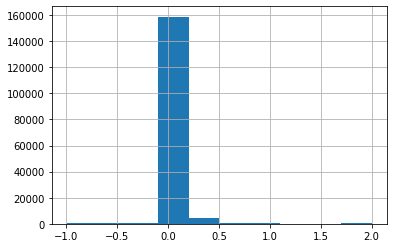

In [294]:
dta_file["divchg"].hist()

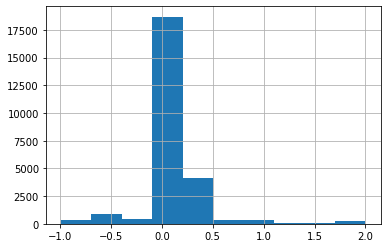

In [297]:
dta_file[dta_file["divchg"]!=0]["divchg"].hist()

In [302]:
dta_file.describe()

,permno,dclrdt_year,divchg,divchg_pos_rank,divchg_neg_rank,divchg_pos_pret,divchg_neg_pret,ret_20,ret_40,ret_60,...,ocf_ql1_chg,ocf_ql2_chg,ocf_ql3_chg,ocf_ql4_chg,ocf_yrl1_lvl_neg,ocf_yrl1_lvl_neg_sq,ocf_yrl1_lvl_pos_sq,ocf_yrl1_chg_neg,ocf_yrl1_chg_neg_sq,ocf_yrl1_chg_pos_sq
count,165558.000000,165558.000000,165558.000000,165558.000000,165558.000000,165558.000000,165558.000000,165558.000000,165558.000000,165558.000000,...,84312.000000,83285.000000,82319.000000,80882.000000,85058.000000,85058.000000,85058.000000,80647.000000,80647.000000,80647.000000
mean,44593.272442,1992.740601,0.020954,0.069880,0.005542,0.001615,0.000497,0.000530,0.000534,0.003329,...,0.001787,0.001558,0.001717,0.001642,-0.001638,0.000093,0.019119,-0.018634,0.001648,0.002280
std,23013.388348,12.708271,0.131819,0.204192,0.061533,0.004607,0.004909,0.085943,0.083255,0.085501,...,0.030101,0.029915,0.029231,0.028876,0.009523,0.000645,0.024222,0.036076,0.005381,0.006557
min,10001.000000,1971.000000,-0.990099,0.000000,0.000000,0.000000,0.000000,-0.650704,-0.614482,-0.650927,...,-0.097199,-0.099236,-0.094597,-0.095214,-0.075319,0.000000,0.000000,-0.195871,0.000000,0.000000
25%,24256.000000,1981.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048103,-0.046208,-0.045142,...,-0.011642,-0.011744,-0.011247,-0.011139,0.000000,0.000000,0.004565,-0.022294,0.000000,0.000000
50%,43123.000000,1991.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003522,-0.002973,-0.000607,...,0.001504,0.001422,0.001513,0.001508,0.000000,0.000000,0.011462,0.000000,0.000000,0.000035
75%,60564.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043535,0.042256,0.046388,...,0.014951,0.014852,0.014612,0.014498,0.000000,0.000000,0.023629,0.000000,0.000497,0.001226
max,93429.000000,2016.000000,2.000000,1.000000,1.000000,0.039408,0.078388,1.165463,0.990605,1.622191,...,0.103569,0.100809,0.100247,0.098358,0.000000,0.005673,0.145613,0.000000,0.038366,0.045521
